<a href="https://colab.research.google.com/github/Sachit3133/MAT494HW/blob/master/Neurons_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuron Physiology Data Analysis Exercises

### - Replace the "..." with code and/or values to complete each problem
### - Always execute cells from top to bottom!

In [0]:
# Our preamble
# Always plot in the notebook
%matplotlib inline
# Load the plotting library
import matplotlib.pyplot as plt
# Load the math library
import numpy as np
# Load more science stuff
import scipy
import scipy.constants as constants
# Load pandas to make and manipulated data frames
import pandas as pd
# Load a library for nicer-looking grpahics
import seaborn as sns
# Nice big fonts
sns.set(font_scale=1.5)
# Load a library to turn warnings on and off
import warnings
# Turn off distracting warning messages that you don't need to see and will confuse you
warnings.filterwarnings("ignore")

In [0]:
# Install some packages that you will need
!pip install quantities
# Install the quantities package for keeping track of units and dimensional analysis
import quantities as pq

<hr>

## 1) 

![ghk](https://raw.githubusercontent.com/rgerkin/neuro-data-analysis-course/master/images/ghk.jpg) 

#### The voltage difference between the inside and oustide of the cell, the so-called "membrane potential", is driven by differences in ion concentrations and differences in the permeability of the membrane to those ions.  It is described by the Goldman-Hodgkin-Katz (GHK) equation:

#### $$ v = \frac{RT}{F}ln\frac{\sum_i{p_ic_{i[out]}}}{\sum_i{p_ic_{i[in]}}}$$ 

#### where $v$ is the membrane potential, $R$ is the ideal gas constant, $T$ is the temperature in Kelvin, $F$ is Faraday's constant, $P_i$ is the membrane permeability of ion $i$ (a reflect of how many ion channels are open for it to travel through), $c_{i[in]}$ is (usually) the concentration of ion $i$ inside the cell, and $c_{i[out]}$ is the (usually) concentration of ion $i$ outside the cell.  But when ions have negative charge (e.g. $Cl^-$), "in" and "out" get swapped, because the ion (negative) and the current (positive, by convention) flow in opposite directions.  

#### Use the GHK equation to determinethe membrane potential at 310 degrees Kelvin (37 degrees Celsius, i.e. human body temperature) for the figure above, assuming that $P_{Na} = 0.05$, $P_K = 1$ , and $P_{Cl} = 0.45$

#### 1a)

In [0]:
# Change this to the correct temperature in Kelvin, but keep the attached units
T = 310 * pq.K

# These already have the correct values
R  = constants.R * pq.J / (pq.mol * pq.K)
F = constants.physical_constants['Faraday constant'][0] * pq.C / pq.mol

# These permeabilties have the "correct" values above
P = np.array([0.05, 1, 0.45]) / pq.mM # Permeabilities 

# Put the correct intracellular values in from the figure above (Na, K, Ca).  
C_in = np.array([10, 148, 103]) * pq.mM

# Put the correct extracellular values in from the figure above.  
C_out = np.array([142, 5, 4]) * pq.mM

#### 1b)

In [0]:
# A sum of products can be implemented as a product of arrays in Python.  
# For example:  
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])
np.sum(x*y) # This will add 1*4, 2*5, and 3*6

# Use this technique to create the numerator and denominator of the term inside the `ln` in the GHK equation:  
numerator = np.sum(P*C_out) # This is the sum of P*C_out for each ion 
denominator = np.sum(P*C_in) # This is the sum of P*C_in for each ion

# Finally, we compute the membrane potential v from all of these pieces.  Note that `log` is the natural logarithm (ln) in Python.  
V = (R*T/F) * np.log(numerator/denominator)

# Print the result (units will look weird, don't worry)
V

array(-0.07053335) * J/C

#### 1c) These units look strange, but maybe they are equivalent to voltage, in the same way that "furlongs per fortnight" is equivalent to speed. If so, we can "rescale" to our desired units of $mV$ (hint: it should be near $-70 mV$):

In [0]:
V.rescale("mV")

array(-70.53334545) * mV

#### 1d) And print the result to 3 significant digits:

In [0]:
print("The membrane potential is %.3g mV." % V.rescale("mV"))

The membrane potential is -70.5 mV.


#### 1e) The proud owner of this neuron ate too many bananas, and all of his potassium regulatory mechanisms aren't working.  His extracellular potassium shot up by an additional 10 mM.  What happens to the resting potential of this neuron?  Will this make this cell more or less active?

In [0]:
# Put the correct extracellular values in from the figure above.  
C_out = np.array([142,15,4]) * pq.mM
numerator = np.sum(P*C_out) # This is the sum of P*C_out for each ion 
V = (R*T/F) * np.log(numerator/denominator)
print("The membrane potential is %.3g mV." % V.rescale("mV"))
print("The cell is more active")

The membrane potential is -56.1 mV.
The cell is more active


<hr>

## 2)  

![threshold](https://slideplayer.com/slide/4667714/15/images/6/Action+potential.jpg)

#### Neurons initiate action potentials as a result of positive feedback: first, sodium enters the cell, raising the membrane potential; then, voltage-dependent sodium channels open in response to this change, and let even more sodium in.  The "point of no return" for this process is called the neuron's ***threshold***, and occurs when this positive feedback will continue even in the absence of any additional input to the cell, causing an action potential.  

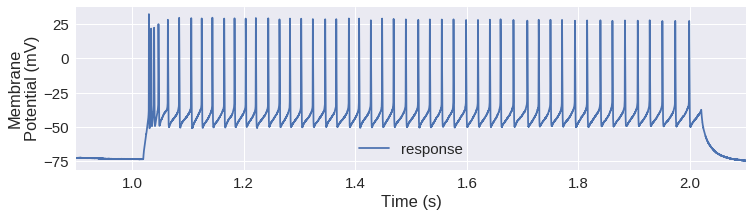

In [0]:
# Load data form the Allen Institute, saved from the previous lecture
url = "https://raw.githubusercontent.com/rgerkin/neuro-data-analysis-course/master/data/sample_trace.csv"
df = pd.read_csv(url, index_col=0) # index_col=0 means that the first column (time) should be the index

# Plot the cell's response (from the data frame column 'response') to the stimulus (not shown, but in column 'stimulus'), on a 12x3 canvas
df.plot(y='response', figsize=(12,3));

# Zoom the x-axis in to the interesting part, starting just before and ending just after the stimulus.  Label the axes.
plt.xlim(0.9, 2.1);
plt.xlabel('Time (s)')
plt.ylabel('Membrane\nPotential (mV)');

#### 2a) How many action potentials (spikes) occurred in response to this stimulus?  Hint: use the example from the most recent lecture if you don't know how to count the number of elements in an array

In [0]:
# Import the function for peak finding.
from scipy.signal import find_peaks

# Find the peak locations and heights, for peaks that go above 0
spike_times, spike_amplitudes = find_peaks(df['response'], height=0)



n_spikes = len(spike_times)



# Write a print statement (as in question #1) that says how many spikes there were.
# Hint: %d will print a value as an integer. 
print("The number of action potentials is %d."% n_spikes)

The number of action potentials is 49.


#### There are many ways to define the threshold, but says that the threshold is when the slope of the membrane potential (the response shown above) suddenly becomes very positive.  

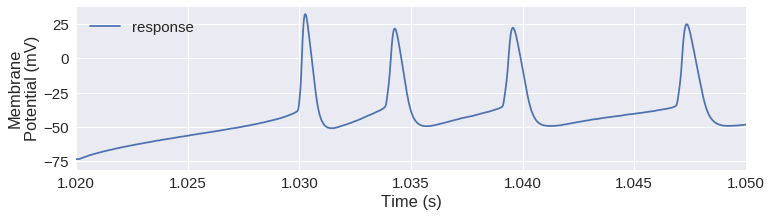

In [0]:
# Plot the cell's response (from the data frame column 'response') to the stimulus (not shown, but in column 'stimulus'), on a 12x3 canvas
df.plot(y='response', figsize=(12,3));

# Zoom the x-axis in to the interesting part, starting just before and ending just after the stimulus
plt.xlim(1.02, 1.05);
plt.xlabel('Time (s)')
plt.ylabel('Membrane\nPotential (mV)');

#### See the event right at (or just before) t = 1.030 seconds?  That is a good example of a threshold (the slope suddenly became very positive). You may recall that the slope is equal to the first derivative (with respect to time).  

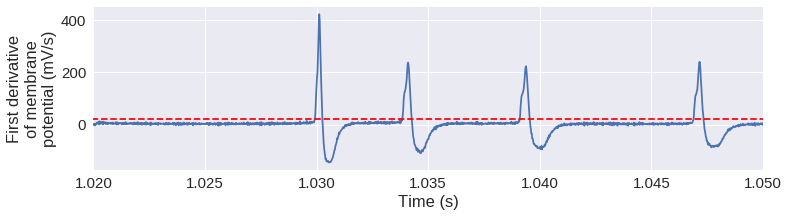

In [0]:
# Compute the first difference (the difference between adjacent samples of the membrane potential)
# This will be in units of "mV" (millivolts)
dv = df['response'].diff() * pq.mV

# Compute the time step (the difference in time from one sample to the next)
# This value is the same for all adjacent time samples, so we can just pick the first two
# This will be in units of "s" (seconds)
dt = (df.index[1] - df.index[0]) * pq.s

# Let's use "ms" (milliseconds) instead because it will be more graphically intuitive
dt = dt.rescale('ms')

# The first derivative with respect to time is dv/dt.  
# Python doesn't allow us to put the "/" sign in a variable name, so we won't.  
# This will have units of "mV/ms"
dvdt = dv/dt

dvdt.plot(figsize=(12,3))

# Zoom the x-axis in to the interesting part, starting just before and ending just after the stimulus
plt.xlim(1.02, 1.05);
plt.xlabel('Time (s)')
plt.ylabel('First derivative\nof membrane\npotential (mV/s)');

# Add a red dotted line at dv/dt = 20 mV/ms
plt.plot([0,2],[20,20],'--r');

#### I've put a red line there to indicate when the slope (dv/dt, shown above) of the original trace (v, shown in the previous figure) gets significantly higher than the baseline. We can call the times when the dv/dt first exceeds this red line, for each spike, the spikes' thresholds.  

#### 2b) Extract all the values from the original dataframe when dv/dt exceeds the value shown in the red line (20 mV/ms)

In [0]:


# You can add a column to any dataframe by just assigning to it with the equals sign.  
# This will give you a new column containing the first derivative that we computed above.  
df["dvdt"] = dvdt

df.head()

# Do you remember how we create a selector (with the double equals sign)?
# You don't have use ==, as you can use >, <, >=, <= or any other comparison operation you can think of.
is_slope_greater_than_threshold = (df["dvdt"] > 20)

# Now do the extraction:  
places_where_slope_is_greater_than_threshold = df[is_slope_greater_than_threshold]

# Show the first rew rows
places_where_slope_is_greater_than_threshold.head()

,stimulus,response,dvdt
1.02992,190.0,-38.2188,20.310
1.02994,190.0,-37.5313,34.375
1.02996,190.0,-36.1250,70.315
1.02998,190.0,-33.7500,118.750
1.03000,190.0,-30.6875,153.125


#### 2c) What is the time point when the first spike (action potential) exceeds threshold?  Note that this will be the first time point in the entire response that exceeds threshold.  

In [0]:
# You can access values from the index of a data frame with .index, 
# and then access entries from that index numerically (e.g. [7] for the 7th value)
t = places_where_slope_is_greater_than_threshold.index[0]
print("The threshold is first crossed at t = %.5g s" % t)

The threshold is first crossed at t = 1.0299 s


#### 2d) What is the membrane potential (not the slope) at that threshold?  Write as a print statement with three significant digits.  Don't forget units!

In [0]:
# You can access value in a column by their index, with .loc[]
v_at_threshold = df.loc[t]["dvdt"] 
print("The memory potential is %.3g" % v_at_threshold )


The memory potential is 20.3


<hr>

## 3) 

#### You may have noticed (by eye) in the original membrane potential trace that the first spikes (action potentials) is taller, narrower, and occurs at a slightly lower threshold than the rest, and that the time between spikes increases.  This is called adaptation, and it is something that many neurons do in response to stimuli.  In fact, many neurons are classified as "adapting" vs. "non-adapting".  

#### Many excitatory cells are adapting, while some notable inhibitory cells are non-adapting.  This means that the "go" neurons can always be overcome by the "stop" neurons, because the "stop" neurons are able to  "fire" spikes at very high rates without slowing down.  This is a negative feedback mechanism which keeps overall activity in line (e.g. preventing seizures).  

#### 3a) Neurons are often classified by an "adapation index", sometimes defined as the ratio between the 3rd and the 1st "inter-spike-interval", or time between spikes.  Using the spike times extracted in question 1, compute the adaptation index for the membrane potential trace that we have been working with.  

In [0]:
# Recall that "spike_indices" is just the row numbers in the data frame where the peaks occurred.  
# First we compute the spike times by using the dataframe's index, and grabbing only those indices that correspond to spike peaks.  
# The .values part here let's us convert to something more intuitive (the values, separated from the dataframe).
# Don't forget to put the units on at the end!

spike_times = df.index[spike_times].values * pq.s
spike_times

array([1.03026, 1.03426, 1.03956, 1.04736, 1.06424, 1.08444, 1.10614,
       1.12488, 1.144  , 1.16518, 1.1837 , 1.20368, 1.22192, 1.24414,
       1.26428, 1.28304, 1.30318, 1.32404, 1.34618, 1.366  , 1.3886 ,
       1.40694, 1.428  , 1.4482 , 1.46882, 1.49074, 1.51298, 1.5337 ,
       1.55516, 1.57616, 1.59872, 1.61998, 1.6413 , 1.6605 , 1.68358,
       1.7084 , 1.72884, 1.74988, 1.77064, 1.79374, 1.81562, 1.8394 ,
       1.86094, 1.88338, 1.90632, 1.92776, 1.95044, 1.9735 , 1.9985 ]) * s

In [0]:
# The inter-spike intervals are just the intervals between spikes, i.e. the differences between adjacent spike times.  
# Here was can use .diff() and not worry about dt because this is actually just a difference between adjacent numbers, not a derivative.  
inter_spike_intervals = np.diff(spike_times)
inter_spike_intervals

array([0.004  , 0.0053 , 0.0078 , 0.01688, 0.0202 , 0.0217 , 0.01874,
       0.01912, 0.02118, 0.01852, 0.01998, 0.01824, 0.02222, 0.02014,
       0.01876, 0.02014, 0.02086, 0.02214, 0.01982, 0.0226 , 0.01834,
       0.02106, 0.0202 , 0.02062, 0.02192, 0.02224, 0.02072, 0.02146,
       0.021  , 0.02256, 0.02126, 0.02132, 0.0192 , 0.02308, 0.02482,
       0.02044, 0.02104, 0.02076, 0.0231 , 0.02188, 0.02378, 0.02154,
       0.02244, 0.02294, 0.02144, 0.02268, 0.02306, 0.025  ]) * s

In [0]:
# Now compute the ratio of the 3rd of these to the 1st of these.
# Don't forget that indices start from 0 in Python (and C, C++, etc.)
# Print to three significant figures
adapation_index = inter_spike_intervals[2]/inter_spike_intervals[0]
print("The adaption index is %.3g" %adapation_index)

The adaption index is 1.95


In [0]:
# Write a statement that is `True` if this adaptation index is >1.5, and `False` if it is not.  
# You could use such a statement as part of a program to sort neurons into "adapting" and "non-adapting" categories.
...

if(adapation_index>1.5):
  print('True')
else:
  print('False')

True


#### 3b) The spikes also get wider. This happens because, after the first spike, not all of the ion channels are ready to participate in the generation of the next spike (some have become inactivated).  This means that the upstroke of the action potential is a bit less vigorous (as is the downstroke, mediating by potassium channels). In milliseconds, how much wider is the second spike than the first?  

1.0302600000000002 s


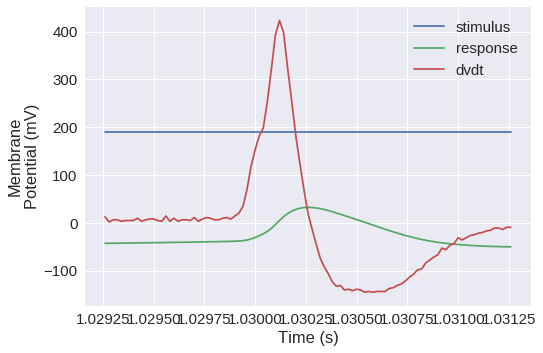

In [122]:
# First we have to figure out the width of one spike.  
# The width is often defined as the time when the membrane potential crosses above the threshold (from question #2) 
# at spike onset until the time when it crosses below it at the end of the spike.  
# Let's give ourselves some runway and extract a period of time +/- 50 samples of the first spike's peak.
# Recall that spike_indices contains the locations of the samples for each spike's peak.  
first_spike_index = spike_times[0]
print(first_spike_index)

# .loc[] is great for finding a location by name in the index.  But the names in our index are time values, and we have indices here.  
# Use .iloc[] (the "i" stands for integer) to access by index.  
first_spike_data = df.loc[[first_spike_index]]

# But we don't just want that exact sample.  We want +/- 50 samples around the spike.  
# You can get a "slice" of the dataframe using a range like .iloc[first:last], where first and last are some values of your choosing.  
first_spike_data_range = df.loc[(1.02926):(1.03126)]


# If all went well, this should like like a plot of the first spike
first_spike_data_range.plot()
plt.xlabel('Time (s)')
plt.ylabel('Membrane\nPotential (mV)');

In [110]:
# Now you need to extract only those values that are above the threshold determined in question #2d.  
# Use a selector to extract only the values in first_spike_data_range that are above that threshold.  
# Note that the threshold is not the value of the red line (which is a threshold for the first derivative), 
# But the actual threshold you got in question #2d.  
is_first_spike_above_threshold = (df["dvdt"]>20.3)
first_spike_above_threshold = first_spike_data_range[is_first_spike_above_threshold]
first_spike_above_threshold.head()

,stimulus,response,dvdt
1.02992,190.0,-38.2188,20.310
1.02994,190.0,-37.5313,34.375
1.02996,190.0,-36.1250,70.315
1.02998,190.0,-33.7500,118.750
1.03000,190.0,-30.6875,153.125


In [117]:
# Now you need to find the difference between the first and last time point in `first_spike_above_threshold`
# This will be the width of the spike.  
# You probably know by now how to access the first element of an array.  
# You can access the last element of an array in several ways, but the coolest is with [-1].  
# Why does the index -1 work?  Imagine that the array was wrapped onto a circle.  If 0 is the first element, than -1 is the last element!
# Don't forget to use .index to access the times (not the membrane potential values), and don't forget to use units!
first_spike_width = (first_spike_above_threshold.index[-1] - first_spike_above_threshold.index[0]) * pq.s
first_spike_width = first_spike_width*1000*pq.ms
# Report the width in ms to three significant figures.
print("%.3g ms"%first_spike_width)

0.34 ms


         stimulus  response  dvdt
1.03426     190.0   21.6875  25.0
The seconds spike is 0.06 ms wider than the first


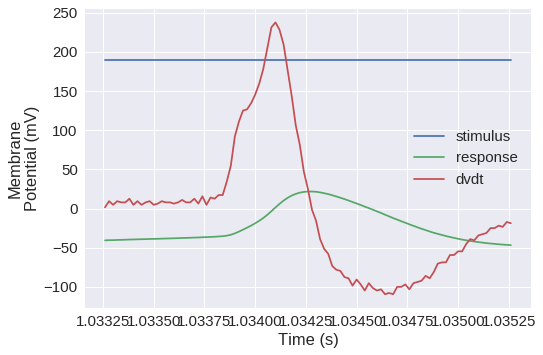

In [125]:
# Finally, you will need to repeat this for the second spike.  
# Note that you will need to obtain the threshold again as you did in question #2, but this time for the second spike instead of the first.
# Hint: at t = 1.032 seconds, the first spike is over and the second spike hasn't begun yet.  You can use this value to extract data for
# only the second spike and beyond, and then repeat the strategy from question #2 to extract it's threshold.  
df_no_first_spike = df[df.index > 1.032]
is_slope_greater_than_threshold = (df_no_first_spike["dvdt"]>20.3)
places_where_slope_is_greater_than_threshold = df_no_first_spike[is_slope_greater_than_threshold]
t = places_where_slope_is_greater_than_threshold.index[0]
v_at_threshold = df_no_first_spike.loc[t]["dvdt"] 
second_spike_index = spike_times[1]
second_spike_data = df_no_first_spike.loc[[second_spike_index]]
print(second_spike_data)
second_spike_data_range = df_no_first_spike.loc[(1.03326):(1.03526)]


# # Plotting is optional
second_spike_data_range.plot()
plt.xlabel('Time (s)')
plt.ylabel('Membrane\nPotential (mV)');

is_second_spike_above_threshold = (df_no_first_spike["dvdt"]>20.3)
second_spike_above_threshold = second_spike_data_range[is_second_spike_above_threshold]
second_spike_width = (second_spike_above_threshold.index[-1] - second_spike_above_threshold.index[0]) * pq.s
second_spike_width = second_spike_width * 1000 
spike_width_difference = second_spike_width - first_spike_width
print("The seconds spike is %.3g ms wider than the first" % spike_width_difference )